In [1]:
!pip install torch
!pip install scipy 
!pip install torchmetrics
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from PIL import Image
import random
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import pickle
from sklearn import manifold
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report
import scipy.io
from google.colab import drive
drive.mount("/content/gdrive",force_remount=True)

Mounted at /content/gdrive


In [3]:
import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18
from torchvision.transforms import transforms

In [4]:
import wandb
wandb.login(key="1262a78bcdb91721d1f31364cec1d26409dd981e")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ishit20380 (drake). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import wandb
import random
# settings=wandb.Settings(start_method="fork")
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="my-awesome-project",
    
    # track hyperparameters and run metadata
    config={
    "learning_rate": 0.02,
    "architecture": "CNN",
    "dataset": "CIFAR-100",
    "epochs": 10,
    }
    
)

# simulate training
epochs = 10
offset = random.random() / 5
for epoch in range(2, epochs):
    acc = 1 - 2 ** -epoch - random.random() / epoch - offset
    loss = 2 ** -epoch + random.random() / epoch + offset
    
    # log metrics to wandb
    wandb.log({"acc": acc, "loss": loss})
    
# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

train accuracy,▁
train loss,▁
train accuracy,0.5393
train loss,2.24191


acc,▁▆▅▇▇▇██
loss,▆█▅▂▂▃▁▁
acc,0.93089
loss,0.0835


## PART 1

In [14]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

data = scipy.io.loadmat("/content/gdrive/MyDrive/cv1.mat")
data['y'][ data['y'] == 10 ] = 0
# data_size = len(data['y'])
data_size = 2000

transform = transforms.Compose(
    
    [   
        transforms.ToTensor(),
        transforms.Resize((32,32)),
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
     ])

import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, data ,transform=None, target_transform=None):
        self.img_labels = data['y']
        self.img_dir = data['X']
        self.transform = transform
        self.data = data

        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = self.data['X'][:,:,:,idx]
        label = self.data['y'][idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        # print(idx)
        return image.float(), label


# shuffle
indices = list(range(data_size))
np.random.shuffle(indices)

test_size =  int(  0.10*data_size )
val_size =   int(  0.20*data_size )
train_size = int(  0.70*data_size )


# test_index =  indices[:test_size]
# train_index = indices[test_size:test_size+train_size]
# val_index = indices[-val_size:]

# xt = data['X'][:train_size]
# yt = data['y'][:train_size]
# data_train = {'X':xt,'y':yt}

# xt = data['X'][train_size:train_size+test_size]
# yt = data['y'][train_size:train_size+test_size]
# data_test = {'X':xt,'y':yt}

# xt = data['X'][-val_size:]
# yt = data['y'][-val_size:]
# data_val = {'X':xt,'y':yt}

xt = data['X'][:train_size]
yt = data['y'][:train_size]
data_train = {'X':xt,'y':yt}

xt = data['X'][:test_size]
yt = data['y'][:test_size]
data_test = {'X':xt,'y':yt}

xt = data['X'][-val_size:]
yt = data['y'][-val_size:]
data_val = {'X':xt,'y':yt}

In [15]:
# x = np.arange(1,10)
# p = np.array([1,2,3])
# x[p]

In [16]:
# for i in range(test_size,-val_size+data_size):
#   if(data['X'][:,:,:,i].shape!=((32, 32, 3))):
#     print("yo!!")
#     break


In [17]:
train = CustomImageDataset(data_train,transform)
test =  CustomImageDataset(data_test,transform)
val =  CustomImageDataset(data_val,transform)

trainloader = torch.utils.data.DataLoader(train, batch_size=256,num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=256,num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=256,num_workers=2)

In [18]:
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

In [19]:
print(images.shape)

torch.Size([256, 3, 32, 32])


tensor([2], dtype=torch.uint8)


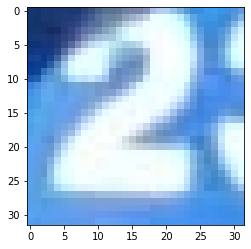

In [168]:
idx = 2
plt.imshow(images[idx].permute(1,2,0))
print(labels[idx])

In [169]:
data = scipy.io.loadmat("/content/gdrive/MyDrive/cv1.mat")
y_train = data['y'][:train_size]
y_val = data['y'][-val_size:]

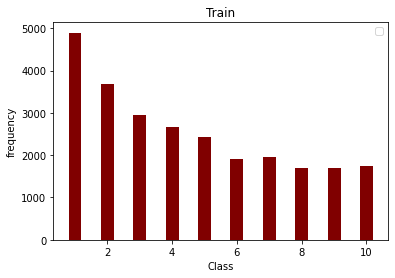

In [ ]:
# visualizing
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, color ='maroon',
        width = 0.4)
plt.title("Train")

plt.xlabel("Class")
plt.ylabel("frequency")
plt.legend()

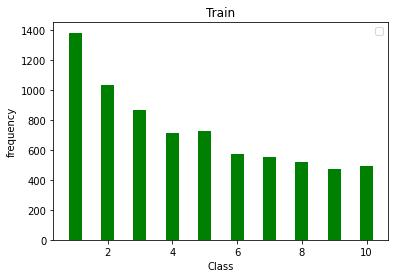

In [ ]:
unique, counts = np.unique(y_val, return_counts=True)
plt.bar(unique, counts, color ='green',
        width = 0.4)
plt.title("Train")

plt.xlabel("Class")
plt.ylabel("frequency")
plt.legend()

## Part 2

In [30]:
# part (a)
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=1)
        self.relu1 = ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.relu2 = ReLU()
        self.fc1 = nn.Linear(65536, 128)
        self.relu3 = ReLU()
        self.fc2 = nn.Linear(128, 10)
        # self.logSoftmax = LogSoftmax(dim=1)
      
    def forward(self,x):
        x = self.relu1((self.conv1(x)))
        x = self.relu2((self.conv2(x)))
        # x = relu2((self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        # output = self.logSoftmax(x)
        return x

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

model = CNN()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
criterion =  nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [52]:
# part (a)
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3,3), padding=1)
        self.relu1 = ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.relu2 = ReLU()
        self.fc = nn.Linear(65536, 10)
        # self.drop = nn.Dropout2d(0.2)
        # self.drops = drops
        # self.relu3 = ReLU()
        # self.fc2 = nn.Linear(128, 10)
        # self.logSoftmax = LogSoftmax(dim=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        torch.nn.init.kaiming_uniform_(self.fc.weight)

    def forward(self,x):
        x = self.conv1(x)
        x=self.relu1(x)
        x=self.conv2(x)
        x=self.relu2(x)

        # if self.drops=="after_conv":
        #   x = self.drop(x)

        x = torch.flatten(x, 1) 
        x = self.fc(x)

        # if self.drops=="after_fc":
        #   x = self.drop(x)
        
        return x

from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD

model = RNN()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=0.001)
criterion =  nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

RNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (fc): Linear(in_features=65536, out_features=10, bias=True)
)


In [53]:
# optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)
loss_fn = CrossEntropyLoss()
optimiser = Adam(model.parameters(), lr=0.001)

In [54]:
total_loss_train = []
total_loss_validation = []

## command to log gradients to wandb
# wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis

for epoch in range(10):  
    print(epoch + 1)
    
    batch_loss_train=0
    batch_loss_val=0

    num_batches = 0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimiser.zero_grad()
        outputs = model(inputs)
        # print(labels)
        labels = labels.reshape((len(labels),))
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimiser.step()

        batch_loss_train+=loss.item()
        running_loss = loss.item()
        # print('[epoch, batch] =  [%d, %5d] loss: %.6f' %(epoch + 1, i, running_loss))
        num_batches+=1

    batch_loss_train/=num_batches
    print("Trianing Loss ",batch_loss_train)

    total_loss_train.append(batch_loss_train)
    
    # Valdiation Loop
    with torch.no_grad():
      correct = 0
      total = 0
      cnt=0
      # ✨ W&B: parameters
      log_counter = 0
      i=-1
      for data in valloader:
          i+=1
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)

          # Get Prediction
          outputs = model(inputs)

          # Compute loss 
          total += labels.size(0)
          cnt+=1
          #labels = labels.float()
          labels = labels.reshape((len(labels),))
          #print(outputs.shape)
          loss_val = criterion(outputs, labels)
          batch_loss_val += loss_val.item()
          
          predicted = [np.argmax(x) for x in outputs]
          predicted = torch.Tensor(predicted).to(device)
          correct += (predicted == labels).sum().item()

  
      acc = 100 * correct / total
      total_loss_validation += [batch_loss_val/cnt]
      # ✨ W&B: Log accuracy across training epochs, to visualize in the UI
      # wandb.log(
      #     {"accuracy" : acc , "Train_loss":batch_loss_train, "Val_loss": batch_loss_val}
      #     )


      print("Validation loss is ",batch_loss_val/cnt)
      print("Validation Acc is ", acc)

print('Finished Training')

1
Trianing Loss  6.931912978490193
Validation loss is  3.543587803840637
Validation Acc is  7.0
2
Trianing Loss  2.9327918688456216
Validation loss is  2.3787015676498413
Validation Acc is  16.25
3
Trianing Loss  2.2477089166641235
Validation loss is  2.3038030862808228
Validation Acc is  16.25
4
Trianing Loss  2.1519962151845298
Validation loss is  2.3048486709594727
Validation Acc is  15.25
5
Trianing Loss  2.0787654320398965
Validation loss is  2.370950698852539
Validation Acc is  14.25
6
Trianing Loss  1.986655056476593
Validation loss is  2.3790425062179565
Validation Acc is  13.75
7
Trianing Loss  1.8597976167996724
Validation loss is  2.4488039016723633
Validation Acc is  11.0
8
Trianing Loss  1.7103493213653564
Validation loss is  2.530686378479004
Validation Acc is  10.75
9
Trianing Loss  1.5473419229189556
Validation loss is  2.6641112565994263
Validation Acc is  10.0
10
Trianing Loss  1.3903131484985352
Validation loss is  2.8277366161346436
Validation Acc is  10.5
Finished 

In [36]:
wandb.init(
    # set the wandb project where this run will be logged
    project="Q1",
)
## command to log gradients to wandb
wandb.watch(model)  ## pass name of model for which we want to log gradients, helps for analysis


# LEN_TRAIN = train_size
for epoch in range(5):
    
    train_accuracy = 0
    test_accuracy = 0
    
    # Train
    model.train()
    f1_true = torch.tensor([])
    f1_pred = torch.tensor([])

    #
    misclassified_img = torch.tensor([])
    misclassified_label = torch.tensor([])
    
    with tqdm(trainloader, unit="batch") as tepoch:
        for image,label in tepoch:
            optimiser.zero_grad()
            
            image = image.to(device)
            train_prob = model(image)
            train_prob = train_prob.cpu()
            
            label = torch.reshape(label, (-1,)).long()
            loss = loss_fn(train_prob, label)
            loss.backward()
            optimiser.step()
            
            train_pred = torch.max(train_prob, 1).indices
            train_accuracy += int(torch.sum(train_pred == label))

            f1_true = torch.cat((f1_true, label))
            f1_pred = torch.cat((f1_pred, train_pred))
            
            # count = 0
            # for i in range(len(train_pred)):
            #   if(count == 3):
            #     break
            #   if(train_pred[i]!=label[i]):
            #       misclassified_img = torch.cat((misclassified_img,image))
            #       misclassified_label = torch.cat((misclassified_label, train_pred))
            #       count+=1
        tr_loss = loss    
        print(train_accuracy)
        train_accuracy_epoch = (train_accuracy / train_size)

        wandb.log(
          {"train accuracy" : train_accuracy_epoch,"train loss":loss}
          )
    
    # validation_loss, accuracy = validation(model, testloader, criterion)
    # Evaluate
    model.eval()
    # with torch.no_grad():
    #       validation_loss, accuracy = validation(model, trainloader, criterion)


    with torch.no_grad():
        for image,label in valloader:
            image = image.to(device)
            test_prob = model(image)
            test_prob = test_prob.cpu()
            label = torch.reshape(label, (-1,)).long()
            test_pred = torch.max(test_prob,1).indices
            test_accuracy += int(torch.sum(test_pred == label))
            label = torch.reshape(label, (-1,)).long()
            loss = loss_fn(test_prob, label)            
            count = 0
            for i in range(len(test_pred)):
              if(count == 3):
                break
              if(test_pred[i]!=label[i]):
                  misclassified_img = torch.cat((misclassified_img,image))
                  misclassified_label = torch.cat((misclassified_label, train_pred))
                  count+=1


            
        test_accuracy_epoch = test_accuracy / val_size

        wandb.log(
          {"val accuracy" : test_accuracy_epoch,"val loss":loss}
          )
    # test_accuracy_epoch = 0
    
    print(f"Epoch: {epoch+1}  , Loss: {tr_loss} , Train_acc: {train_accuracy_epoch}, Test_acc: {test_accuracy_epoch} , Val Loss:{loss}")


# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('model.pth')
# wandb.log_artifact(artifact)

train accuracy,▁▆██
train loss,█▂▁▁
val accuracy,█▃▂▁
val loss,▁▅▇█
train accuracy,0.82359
train loss,0.73803
val accuracy,0.12156
val loss,6.09444


100%|██████████| 6/6 [00:08<00:00,  1.48s/batch]

374


Epoch: 1  , Loss: 1.984862208366394 , Train_acc: 0.2671428571428571, Test_acc: 0.155 , Val Loss:2.383941173553467


100%|██████████| 6/6 [00:09<00:00,  1.56s/batch]

400


Epoch: 2  , Loss: 1.9134963750839233 , Train_acc: 0.2857142857142857, Test_acc: 0.155 , Val Loss:2.413924217224121


100%|██████████| 6/6 [00:07<00:00,  1.22s/batch]

443


Epoch: 3  , Loss: 1.8289217948913574 , Train_acc: 0.31642857142857145, Test_acc: 0.1375 , Val Loss:2.4576807022094727


100%|██████████| 6/6 [00:08<00:00,  1.44s/batch]

484


Epoch: 4  , Loss: 1.7294977903366089 , Train_acc: 0.3457142857142857, Test_acc: 0.1375 , Val Loss:2.528925895690918


100%|██████████| 6/6 [00:09<00:00,  1.54s/batch]

520


Epoch: 5  , Loss: 1.6279717683792114 , Train_acc: 0.37142857142857144, Test_acc: 0.135 , Val Loss:2.620059013366699


tensor([6], dtype=torch.uint8)


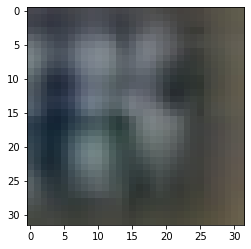

In [ ]:
len(misclassified_img)

idx = -7
misclassified_img[idx]

plt.imshow(misclassified_img[idx].permute(1,2,0))
print(labels[idx])

tensor([7], dtype=torch.uint8)


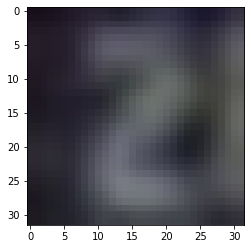

In [ ]:
idx = -16
misclassified_img[idx]

plt.imshow(misclassified_img[idx].permute(1,2,0))
print(labels[idx])

In [ ]:
from torchmetrics.classification import F1Score
# print(f1_true)
# print(f1_pred)
f1 = F1Score(task="multiclass", num_classes=10)
f1(f1_pred, f1_true)

tensor(0.6937)

In [156]:
f1_true = torch.tensor([])
f1_pred = torch.tensor([])

with torch.no_grad():
        for image,label in valloader:
            image = image.to(device)
            test_prob = model(image)
            test_prob = test_prob.cpu()
            label = torch.reshape(label, (-1,)).long()
            test_pred = torch.max(test_prob,1).indices
            test_accuracy += int(torch.sum(test_pred == label))
            label = torch.reshape(label, (-1,)).long()
            # loss = loss_fn(test_prob, label)

            count = 0
            for i in range(len(test_pred)):
              if(count == 3):
                break
              if(test_pred[i]!=label[i]):
                  misclassified_img = torch.cat((misclassified_img,image))
                  misclassified_label = torch.cat((misclassified_label, train_pred))
                  count+=1

            f1_true = torch.cat((f1_true, label))
            f1_pred = torch.cat((f1_pred, test_prob))
            
        test_accuracy_epoch = test_accuracy / test_size

        wandb.log(
          {"test accuracy" : test_accuracy_epoch,"test loss":loss}
          )
        

from torchmetrics.classification import F1Score
# print(f1_true)
# print(f1_pred)
f1 = F1Score(task="multiclass", num_classes=10)
print(f1(f1_pred, f1_true))
print(test_accuracy_epoch)

tensor(0.1682)
1.0098360655737706



## Trash

In [ ]:
#   for epoch in range(1):  # loop over the dataset multiple times

#     running_loss = 0.0
#     for i, data in enumerate(trainloader, 0):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         inputs.float()
#         # zero the parameter gradients
#         optimizer.zero_grad()

#         # forward + backward + optimize
#         outputs = model(inputs)
#         labels = torch.reshape(labels, (-1,)).long()
#         # print(labels)
#         loss = criterion(outputs, labels)
#         print(loss)
#         loss.backward()
#         optimizer.step()

#         # print statistics
#         running_loss += loss.item()
#         print(running_loss)

#         # print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#         if i % 10 == 1999:    # print every 2000 mini-batches
#             print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
#             running_loss = 0.0

# print('Finished Training')

In [ ]:
# # data_size = len(data['X'])
# data_size = 2000

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# # shuffle
# indices = list(range(data_size))
# np.random.shuffle(indices)

# test_size =  int(  0.10*data_size )
# val_size =   int(  0.20*data_size )
# train_size = int(  0.70*data_size )


# test_index =  indices[:test_size]
# train_index = indices[test_size:test_size+train_size]
# val_index = indices[-val_size:]

# # df_test = torch.tensor(torch.tensor(data['X'][test_index]),torch.tensor(data['y'][test_index]))

# # from torch.utils.data import TensorDataset
# # label = torch.tensor(data['y'],)
# # img_arr = torch.tensor(data['X'])
# # df = TensorDataset(img_arr, label)


# gen = torch.Generator()
# gen.manual_seed(42)

# train_sampler=SubsetRandomSampler(train_index, generator=gen)
# val_sampler=SubsetRandomSampler(val_index, generator=gen)
# test_sampler=SubsetRandomSampler(test_index, generator=gen)

# batch_size = 64
# trainloader = torch.utils.data.DataLoader(df, sampler = train_sampler, batch_size=batch_size,num_workers=2)
# # valloader = torch.utils.data.DataLoader(df, sampler = val_sampler, batch_size=batch_size,num_workers=2)
# # testloader = torch.utils.data.DataLoader(df,sampler = test_sampler, batch_size=batch_size,num_workers=2)

In [ ]:
# training
y_train = data['y'][train_index]
y_val = data['y'][val_index]

<BarContainer object of 10 artists>

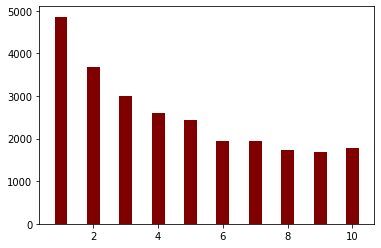

In [ ]:
unique, counts = np.unique(y_train, return_counts=True)
plt.bar(unique, counts, color ='maroon',
        width = 0.4)

<BarContainer object of 10 artists>

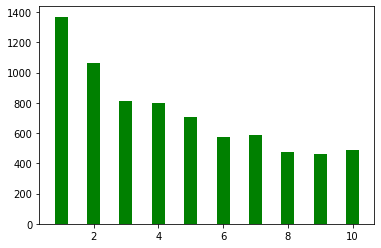

In [ ]:
unique, counts = np.unique(y_val, return_counts=True)
plt.bar(unique, counts, color ='green',
        width = 0.4)

## RESNET

In [ ]:
# https://github.com/shounak8/AIML_Tutotials/blob/master/Deep_Learning/PyTorch/santa_or_not/santa_pytorch_pretrained_model.ipynb

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

In [ ]:
model = resnet18(pretrained=True) # using pre trained resnet
model.fc = Linear(in_features=512, out_features=10)  # changing the dimensions of last output layer to number of classes
model = model.to(device) # using gpu

optimizer = Adam(model.parameters(), lr=0.01) # choosing optimizer and setting cross entropy loss
loss_function = CrossEntropyLoss() 

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model = resnet18(pretrained=True)   #load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 10) #(num_of_class == 2)
model = model.to(device) 
loss_fn = nn.CrossEntropyLoss()  #(set loss function)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
import glob
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
from torchvision.io import read_image


# data = scipy.io.loadmat("/content/gdrive/MyDrive/cv1.mat")
# data['y'][ data['y'] == 10 ] = 0

# xt = data['X'][:2000]
# yt = data['y'][:2000]
# data_train = {'X':xt,'y':yt}

# xt = data['X'][200:1500]
# yt = data['y'][200:1500]
# data_test = {'X':xt,'y':yt}

# train = CustomImageDataset(data_train,transform)
# # # test =  CustomImageDataset(data_test,transform)

# trainloader = torch.utils.data.DataLoader(train, batch_size=64,num_workers=2)
# # testloader = torch.utils.data.DataLoader(test, batch_size=64,num_workers=2)

# LEN_TRAIN = train_size
for epoch in range(5):
    
    train_accuracy = 0
    test_accuracy = 0
    
    # Train
    model.train()
    f1_true = torch.tensor([])
    f1_pred = torch.tensor([])

    #
    misclassified_img = torch.tensor([])
    misclassified_label = torch.tensor([])
    
    with tqdm(trainloader, unit="batch") as tepoch:
        for image,label in tepoch:
            optimizer.zero_grad()
            
            image = image.to(device)
            train_prob = model(image)
            train_prob = train_prob.cpu()
            
            label = torch.reshape(label, (-1,)).long()
            loss = loss_fn(train_prob, label)
            loss.backward()
            optimizer.step()
            
            train_pred = torch.max(train_prob, 1).indices
            train_accuracy += int(torch.sum(train_pred == label))

            f1_true = torch.cat((f1_true, label))
            f1_pred = torch.cat((f1_pred, train_pred))
            
            
            

        train_accuracy_epoch = (train_accuracy / train_size)
    
    # Evaluate
    # model.eval()
    # with torch.no_grad():
    #     for image,label in testloader:
    #         image = image.to(device)
    #         test_prob = model(image)
    #         test_prob = test_prob.cpu()
            
    #         test_pred = torch.max(test_prob,1).indices
    #         test_accuracy += int(torch.sum(test_pred == label))
    #         if(test_pred != label):
    #           misclassified_img = torch.cat((misclassified,image))
    #           misclassified_lael = torch.cat((misclassified_lael, train_pred))

            
    #     test_accuracy_epoch = test_accuracy / test_size
    test_accuracy_epoch = 0
    
    print(f"Epoch: {epoch}  , Loss: {loss} , Train_acc: {train_accuracy_epoch}, Test_acc: {test_accuracy_epoch}")

100%|██████████| 101/101 [01:06<00:00,  1.52batch/s]


Epoch: 0  , Loss: 2.4517643451690674 , Train_acc: 0.16367608051178031, Test_acc: 0


100%|██████████| 101/101 [01:21<00:00,  1.24batch/s]


Epoch: 1  , Loss: 2.6714444160461426 , Train_acc: 0.1770947105632704, Test_acc: 0


100%|██████████| 101/101 [01:07<00:00,  1.49batch/s]


Epoch: 2  , Loss: 2.551065444946289 , Train_acc: 0.1830238726790451, Test_acc: 0


100%|██████████| 101/101 [01:09<00:00,  1.45batch/s]


Epoch: 3  , Loss: 2.5716419219970703 , Train_acc: 0.18614448431892652, Test_acc: 0


100%|██████████| 101/101 [01:08<00:00,  1.47batch/s]

Epoch: 4  , Loss: 1.9497307538986206 , Train_acc: 0.1942580745826182, Test_acc: 0


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


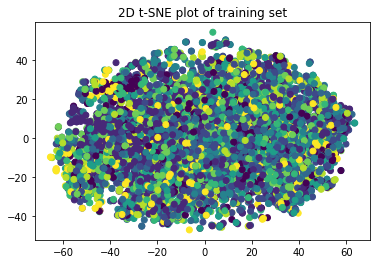

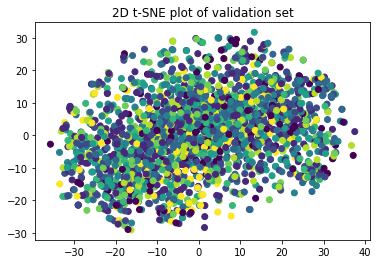

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


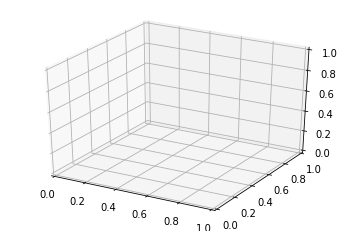

In [ ]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings("ignore")

# Load pre-trained ResNet-18 model and freeze weights
resnet = resnet18(pretrained=True)
for param in resnet.parameters():
    param.requires_grad = False

# Extract feature vectors for training and validation sets
train_features = []
train_labels = []
for images, labels in trainloader:
    with torch.no_grad():
        features = resnet(images)
    train_features.append(features.cpu().numpy())
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels)

val_features = []
val_labels = []
for images, labels in valloader:
    with torch.no_grad():
        features = resnet(images)
    val_features.append(features.cpu().numpy())
    val_labels.append(labels.numpy())

val_features = np.concatenate(val_features)
val_labels = np.concatenate(val_labels)

# Reduce dimensionality of feature vectors using t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=0)
train_tsne = tsne.fit_transform(train_features)
val_tsne = tsne.fit_transform(val_features)

# Visualize 2D t-SNE plot of training set
plt.scatter(train_tsne[:, 0], train_tsne[:, 1], c=train_labels)
plt.title('2D t-SNE plot of training set')
plt.show()

# Visualize 2D t-SNE plot of validation set
plt.scatter(val_tsne[:, 0], val_tsne[:, 1], c=val_labels)
plt.title('2D t-SNE plot of validation set')
plt.show()

# Reduce dimensionality of feature vectors using t-SNE for 3D plot
tsne_3d = TSNE(n_components=3, perplexity=30, random_state=0)
val_tsne_3d = tsne_3d.fit_transform(val_features)

# Visualize 3D t-SNE plot of validation set
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax

In [ ]:
from torchmetrics.classification import F1Score
# print(f1_true)
# print(f1_pred)
f1 = F1Score(task="multiclass", num_classes=10)
f1(f1_pred, f1_true)

tensor(0.0905)

In [ ]:
labels = None
features = None
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        features = model.get_features(images)
      
print(features)

tensor([[ 1.0732, -0.1563, -0.9011,  ..., -3.4389, -1.0389, -0.7465],
        [-0.6167, -0.8459, -0.2426,  ...,  0.2298,  0.2022,  0.2082],
        [ 1.5768,  0.8436,  0.0436,  ..., -0.2039, -0.0534,  0.1282],
        ...,
        [-0.1947, -1.3528, -1.0856,  ...,  0.9888, -0.0083, -1.0834],
        [ 1.5978,  0.2717,  0.2054,  ..., -1.5825, -1.1811,  0.9422],
        [ 1.9095,  0.2840, -0.2494,  ...,  0.7040, -1.0199, -2.8788]])


In [ ]:
LEN_TRAIN = 2000
for epoch in range(2):
    
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    

    f1_true = torch.tensor([])
    f1_pred = torch.tensor([])

  
    
    with tqdm(trainloader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            


            ytrain = torch.reshape(ytrain, (-1,)).long()

            

            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices

            f1_true = torch.cat((f1_true, ytrain))
            f1_pred = torch.cat((f1_pred, train_pred))

            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    # model.eval()
    # with torch.no_grad():
    #     for xtest, ytest in test_loader:
    #         xtest = xtest.to(device)
    #         test_prob = model(xtest)
    #         test_prob = test_prob.cpu()
            
    #         test_pred = torch.max(test_prob,1).indices
    #         test_acc += int(torch.sum(test_pred == ytest))
            
    #     ep_test_acc = test_acc / LEN_TEST
    
   
    
    print(f"Epoch: {epoch}, Time: {0}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {0}")

100%|██████████| 32/32 [00:17<00:00,  1.83batch/s]


Epoch: 0, Time: 0, Loss: 2.636685371398926
Train_acc: 0.0905, Test_acc: 0


100%|██████████| 32/32 [00:18<00:00,  1.75batch/s]

Epoch: 1, Time: 0, Loss: 2.636685371398926
Train_acc: 0.0905, Test_acc: 0


In [ ]:
ytrain = torch.reshape(ytrain, (-1,)).long()
ytrain

tensor([8, 4, 1, 2, 9, 5, 6, 2, 9, 1, 1, 5, 2, 1, 3, 3])

In [ ]:
torch.max(train_prob, 1)

torch.return_types.max(
values=tensor([0.9538, 0.7797, 1.3748, 1.5034, 1.3536, 0.7009, 1.2162, 1.0941, 1.3805,
        1.3677, 2.2909, 1.6346, 1.1408, 1.1597, 1.2788, 0.7480],
       grad_fn=<MaxBackward0>),
indices=tensor([0, 2, 5, 3, 2, 5, 4, 4, 2, 6, 6, 5, 6, 6, 6, 2]))

In [ ]:
a = torch.randn(1, 3)
a

tensor([[ 0.5987, -0.4885,  1.4049]])

In [ ]:
torch.max(a,1).indices

tensor([2])

In [ ]:
b = torch.randn(1, 3)
b

tensor([[-0.3623,  0.6409, -0.4022]])

In [ ]:
a = torch.cat((a, b))

In [ ]:
b1 = torch.tensor([12,3])
b1

tensor([12,  3])

In [ ]:
a1 = torch.tensor([2,3])
a1

tensor([2, 3])

In [ ]:
f1_true = torch.tensor([])
f1_true = torch.cat((f1_true, labels))


In [ ]:
for i in range(len(a1)):
  print(a1[i] == 2)

tensor(True)
tensor(False)


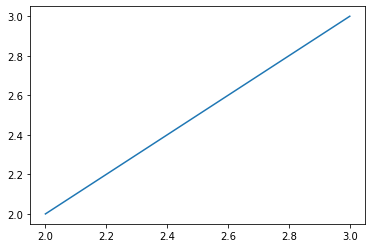

In [ ]:
plt.plot(a1.numpy(),[2,3])

## Part 4

In [ ]:
# Augument the training data
transform = transforms.Compose(
    
    [   
        transforms.ToTensor(),
        transforms.Resize((224, 224)),
        transforms.RandomGrayscale(p=1),
        transforms.RandomRotation(degrees = 45),
        transforms.ColorJitter(brightness=0.75)
    #  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    
     ])

xt = data['X'][:2000]
yt = data['y'][:2000]
ds = {'X':xt,'y':yt}

dataset1 = CustomImageDataset(ds,transform)
dataset2 = CustomImageDataset(ds,transform)

agumented_dataset =  torch.utils.data.ConcatDataset([dataset1, dataset2])
# trainloader = torch.utils.data.DataLoader(dataset, batch_size=64,num_workers=2)

In [ ]:
len(agumented_dataset)

4000

In [ ]:
print(len(dataset),len(ds['X']))

NameError: ignored

In [ ]:
dataset[0]

In [ ]:
ds['y'][0]

In [ ]:
idx = 0
plt.imshow(ds['X'][:,:,:,idx])
print(ds['y'][idx])

In [ ]:
idx = 0
plt.imshow(dataset[idx][0].permute(1,2,0))
print(dataset[idx][1])